In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nlp_assemblee.datasets import (
    build_dataset_and_dataloader_from_config,
    load_records,
)
from nlp_assemblee.models import build_classifier_from_config
from nlp_assemblee.trainer import build_trainer_from_config

In [3]:
import torch
from torchview import draw_graph

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

In [6]:
config_file = "../../configs/simple.json"

classifier = build_classifier_from_config(config_file)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
input_data = {
    "intervention": torch.randint(10, size=(32, 512)).to(device),
}

In [8]:
classifier = classifier.to(device)

In [9]:
classifier(**input_data).shape

torch.Size([32, 3])

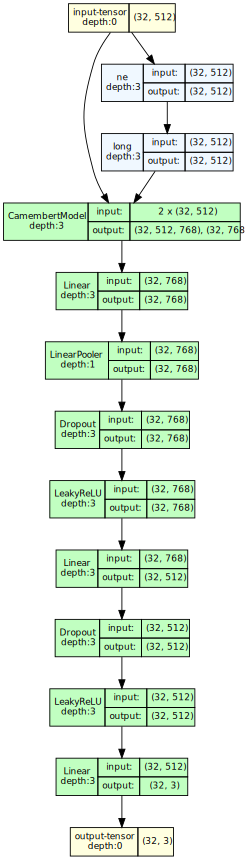

In [10]:
input_data = {
    "intervention": torch.randint(10, size=(32, 512)).to(device),
}

model_graph = draw_graph(classifier, input_data=input_data, device=device)
model_graph.visual_graph

In [11]:
datasets, loaders = build_dataset_and_dataloader_from_config(config_file, "../../")

In [12]:
!nvidia-smi

Sat Feb  4 17:56:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P0    34W /  N/A |   3009MiB /  8192MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
x, y = next(iter(loaders["train"]))

In [25]:
x = {k: v.to(device) for k, v in x.items()}

In [26]:
x

{'intervention': tensor([[    5,    54,   938,  ...,     0,     0,     0],
         [    5,   170, 16589,  ...,     0,     0,     0],
         [    5,    84,    11,  ...,     0,     0,     0],
         ...,
         [    5,   159,    13,  ...,     0,     0,     0],
         [    5,  1198, 12583,  ...,     0,     0,     0],
         [    5,  2445,    16,  ...,     0,     0,     0]], device='cuda:0')}

In [16]:
import json

import pytorch_lightning as pl
import torch
from pytorch_lightning import callbacks
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch import nn

from nlp_assemblee.models import build_classifier_from_config

In [17]:
class LitModel(pl.LightningModule):
    def __init__(
        self,
        classifier,
        criterion,
        optimizer_kwargs,
    ):
        super().__init__()
        self.classifier = classifier

        if criterion == "CrossEntropyLoss":
            self.criterion = nn.CrossEntropyLoss()
        elif criterion == "BCEWithLogitsLoss":
            self.criterion = nn.BCEWithLogitsLoss()

        self.optimizer_kwargs = optimizer_kwargs

    def forward(self, x):
        return self.classifier(**x)

    def configure_optimizers(self):
        if self.optimizer_kwargs["name"] == "Adam":
            optimizer = torch.optim.Adam(
                self.classifier.parameters(), lr=self.optimizer_kwargs["lr"]
            )
        elif self.optimizer_kwargs["name"] == "SGD":
            optimizer = torch.optim.SGD(
                self.classifier.parameters(), lr=self.optimizer_kwargs["lr"]
            )
        return optimizer

    def get_loss(self, batch, model_type="train"):
        x, y = batch
        z = self.classifier(**x)
        loss = self.criterion(z, y)
        self.log(f"{model_type}_loss", loss)
        return loss

    def training_step(self, batch, batch_idx):
        tain_loss = self.get_loss(batch, model_type="train")
        return tain_loss

    def validation_step(self, val_batch, batch_idx):
        val_loss = self.get_loss(val_batch, model_type="val")
        return val_loss

    def testing_step(self, val_batch, batch_idx):
        test_loss = self.get_loss(val_batch, model_type="test")
        return test_loss

In [18]:
lit_model = LitModel(classifier, "CrossEntropyLoss", {"name": "Adam", "lr": 1e-3})

In [22]:
trainer = pl.Trainer(
    accelerator="gpu",
    profiler="simple",
    max_epochs=30,
    default_root_dir="../../",
    fast_dev_run=True,
    # overfit_batches=1,
    callbacks=[
        callbacks.EarlyStopping(monitor="val_loss", mode="min", check_finite=True, patience=5),
        callbacks.ModelSummary(),
        callbacks.Timer(duration="00:03:00:00", interval="epoch"),  # Max three hours
    ],
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [29]:
from torch.profiler import ProfilerActivity, profile, record_function

with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        classifier.to(device)(**x)

STAGE:2023-02-04 18:30:14 38281:38281 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-02-04 18:30:15 38281:38281 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [23]:
trainer.fit(model=lit_model, train_dataloaders=loaders["train"], val_dataloaders=loaders["val"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | classifier | Classifier       | 111 M 
1 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
985 K     Trainable params
110 M     Non-trainable params
111 M     Total params
446.431   Total estimated model params size (MB)
/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.
FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                   